# TP1: Conversion of Sampling Frequency and STFT

*By Daniel Jorge Deutsch, Kevin Kuhl and Brayam Santiago Velandia (25/09/2020)*

In [102]:
import os
import struct
import sys
import wave
from copy import deepcopy
from math import ceil

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyaudio
from scipy import signal as sig
from scipy.io import wavfile

In [103]:
class Signal:

    def __init__(self, name, signal=None, freq=None, file=None):

        if not (file or not signal is None):
            raise Exception("You must at least pass a signal or a .wav file")
        if file and not signal is None:
            raise Exception("You can only pass a signal or a .wav file (not both)")

        self.name = name 

        if not signal is None:
            self.signal = np.asarray(signal)
            self.freq = int(freq) if freq else freq
        if file:
            self.file = file
            self.freq, self.signal = wavfile.read(self.file)
            self.freq = int(self.freq)
            self.signal = np.asarray(self.signal)
            
    
    #------------------------------#
    #--- OPERATIONS ---------------#
    #------------------------------#

    def convolve(self, name, signal):
        freq = signal.freq if signal.freq else self.freq
        conv = np.convolve(self.signal, signal.signal)
        return self.__class__(name, signal=conv, freq=freq)


    #------------------------------#
    #--- SAMPLING -----------------#
    #------------------------------#

    def remove_samples(self, name, M, start=0):
        res = self.signal[start::M]
        freq = self.freq/M if self.freq else self.freq
        return self.__class__(name=name, signal=res, freq=self.freq/M)


    def insert_zeros(self, name, L):
        res = np.insert(self.signal, range(1, len(self.signal)+1)[::L-1], 0)
        freq = self.freq*L if self.freq else self.freq
        return self.__class__(name=name, signal=res, freq=self.freq*L)


    #------------------------------#
    #--- PLOTS --------------------#
    #------------------------------#

    def time_plot(self, xhighlights=None, yhighlights=None, figsize=(15, 4), save=False):
        
        # Time axis
        t = np.linspace(-0.5, 0.5, len(self.signal)) ################### ISSO TA ERRADO

        # Plot
        plt.figure(figsize=figsize)
        plt.plot(t, self.signal)
        plt.xlim(t[0], t[-1])
        plt.xlabel("Time [s]")
        plt.ylabel("Amplitude")
        plt.title(f"Time plot of {self.name}")
        if xhighlights:
            for xhighlight in xhighlights:
                plt.axvline(x=xhighlight, color="red")
        if yhighlights:
            for yhighlight in yhighlights:
                plt.hline(x=yhighlight, color="red")
        if save:
            plt.savefig(f"./outputs/figures/{self.name}_time.png", dpi=300, bbox_inches="tight")
        plt.show()

    
    # Should use when you have the filter's coefficients
    def freqz_plot(self, xhighlights=None, yhighlights=None, figsize=(15, 4), save=False):

        freq, mag = sig.freqz(self.signal)

        # Magnitude
        mag = 20*np.log10(np.abs(mag))
        mag[np.abs(mag-np.mean(mag)) > 2*np.std(mag)] = np.nan     # Remove outliers for the plot

        # Frequency   
        freq = freq/(2*np.pi)
        
        # Plot
        plt.figure(figsize=figsize)
        plt.plot(freq, mag)
        plt.xlim(freq[0], freq[-1])
        plt.ylabel("Magnitude [(]dB]")
        plt.xlabel("Frequency [(rad/sample)/2π]")
        plt.title(f"Frequency response of {self.name}")
        if xhighlights:
            for xhighlight in xhighlights:
                plt.axvline(x=xhighlight, color="red")
        if yhighlights:
            for yhighlight in yhighlights:
                plt.hline(y=yhighlight, color="red")
        if save:
            plt.savefig(f"./outputs/figures/{self.name}_freqz.png", dpi=300, bbox_inches="tight")
        plt.show() 

    
    # Should use when you have filter's impulse response
    def fft_plot(self, xhighlights=None, yhighlights=None, figsize=(15, 4), save=False):      
        
        # Magnitude
        len_fft = 4096                                           # Length of the transformed axis of the output
        mag = np.fft.fft(self.signal, len_fft)                   # Obtains the magnitude of the signal
        mag = np.fft.fftshift(mag)                               # Shifts the zero-frequency component to the center of the spectrum
        mag = 20*np.log10(np.abs(mag))                           # Applies log to the result
        mag[np.abs(mag-np.mean(mag)) > 2*np.std(mag)] = np.nan   # Remove outliers for the plot

        # Frequency
        freq = np.linspace(-0.5, 0.5, len(mag))

        # Plot
        plt.figure(figsize=figsize)
        plt.plot(freq, mag)
        plt.xlim(freq[0], freq[-1])
        plt.ylabel("Magnitude [dB]")
        plt.xlabel("Frequency [(rad/sample)/2π]")
        plt.title(f"Frequency response of {self.name}")
        if xhighlights:
            for xhighlight in xhighlights:
                plt.axvline(x=xhighlight, color="red")
        if yhighlights:
            for yhighlight in yhighlights:
                plt.hline(y=yhighlight, color="red")
        if save:
            plt.savefig(f"./outputs/figures/{self.name}_fft.png", dpi=300, bbox_inches="tight")
        plt.show() 

    
    #------------------------------#
    #--- LISTEN -------------------#
    #------------------------------#
    
    def listen(self):
        
        # Saves the .wav
        if not self.freq:
            raise Exception("the sample freq (sample/sec) must be provided")
        wavfile.write(f"./outputs/sounds/{self.name}.wav", self.freq, np.asarray(self.signal, dtype=np.int16))

        # Uses pyaudio to play the signal
        chunk = 1024
        pa = pyaudio.PyAudio()
        audio = wave.open(f"./outputs/sounds/{self.name}.wav", "rb")
        stream = pa.open(
            format = pa.get_format_from_width(audio.getsampwidth()),
            channels = audio.getnchannels(),
            freq = audio.getframefreq(),
            output = True
        )
        data = audio.readframes(chunk)
        while data:
            stream.write(data)
            data = audio.readframes(chunk)
        stream.stop_stream()
        stream.close()
        pa.terminate()

In [104]:
class Filter:

    def __init__(self, name, signal):
        self.name = name
        self.signal = signal

    
    def apply(self, name, signal):
        conv = np.convolve(self.signal, signal.signal)
        return Signal(name, signal=conv, freq=signal.freq)

    
    def time_plot(self, xhighlights=None, yhighlights=None, figsize=(15, 4), save=False):
        
        # Time axis
        t = np.linspace(-0.5, 0.5, len(self.signal)) ################### ISSO TA ERRADO

        # Plot
        plt.figure(figsize=figsize)
        plt.plot(t, self.signal)
        plt.xlim(t[0], t[-1])
        plt.xlabel("Time [s]")
        plt.ylabel("Amplitude")
        plt.title(f"Time plot of {self.name}")
        if xhighlights:
            for xhighlight in xhighlights:
                plt.axvline(x=xhighlight, color="red")
        if yhighlights:
            for yhighlight in yhighlights:
                plt.hline(x=yhighlight, color="red")
        if save:
            plt.savefig(f"./outputs/figures/{self.name}_time.png", dpi=300, bbox_inches="tight")
        plt.show()

    
    # Should use when you have the filter's coefficients
    def freqz_plot(self, xhighlights=None, yhighlights=None, figsize=(15, 4), save=False):

        freq, mag = sig.freqz(self.signal)

        # Magnitude
        mag = 20*np.log10(np.abs(mag))
        mag[np.abs(mag-np.mean(mag)) > 2*np.std(mag)] = np.nan     # Remove outliers for the plot

        # Frequency   
        freq = freq/(2*np.pi)
        
        # Plot
        plt.figure(figsize=figsize)
        plt.plot(freq, mag)
        plt.xlim(freq[0], freq[-1])
        plt.ylabel("Magnitude [(]dB]")
        plt.xlabel("Frequency [(rad/sample)/2π]")
        plt.title(f"Frequency response of {self.name}")
        if xhighlights:
            for xhighlight in xhighlights:
                plt.axvline(x=xhighlight, color="red")
        if yhighlights:
            for yhighlight in yhighlights:
                plt.hline(y=yhighlight, color="red")
        if save:
            plt.savefig(f"./outputs/figures/{self.name}_freqz.png", dpi=300, bbox_inches="tight")
        plt.show() 

    
    # Should use when you have filter's impulse response
    def fft_plot(self, xhighlights=None, yhighlights=None, figsize=(15, 4), save=False):      
        
        # Magnitude
        len_fft = 4096                                           # Length of the transformed axis of the output
        mag = np.fft.fft(self.signal, len_fft)                   # Obtains the magnitude of the signal
        mag = np.fft.fftshift(mag)                               # Shifts the zero-frequency component to the center of the spectrum
        mag = 20*np.log10(np.abs(mag))                           # Applies log to the result
        mag[np.abs(mag-np.mean(mag)) > 2*np.std(mag)] = np.nan   # Remove outliers for the plot

        # Frequency
        freq = np.linspace(-0.5, 0.5, len(mag))

        # Plot
        plt.figure(figsize=figsize)
        plt.plot(freq, mag)
        plt.xlim(freq[0], freq[-1])
        plt.ylabel("Magnitude [dB]")
        plt.xlabel("Frequency [(rad/sample)/2π)]")
        plt.title(f"Frequency response of {self.name}")
        if xhighlights:
            for xhighlight in xhighlights:
                plt.axvline(x=xhighlight, color="red")
        if yhighlights:
            for yhighlight in yhighlights:
                plt.hline(y=yhighlight, color="red")
        if save:
            plt.savefig(f"./outputs/figures/{self.name}_fft.png", dpi=300, bbox_inches="tight")
        plt.show()   

In [105]:
# Obtains the input signal x from its file
x = Signal(name="x", file="./inputs/caravan_48khz.wav")

# Defines the over and under sampling constants
L = 2
M = 3

# Obtains the over sampled signal w using L=2 (Fw=48*2=96kHz)
w = x.insert_zeros("w", L)

# Defines the Remez filter params
numtaps = 100                       # An even number (can't be too big)
trans_width = 1/13                  # ?
cutoff = min( 1/(2*L), 1/(2*M) )    # Cutoff frequency (should be 1/(2*M) = 1/6)

# Obtains the Remez filter
h = Filter(name="h", signal=sig.remez(numtaps, [0, cutoff, cutoff+trans_width, 1/2], [L, 0]))

# Calculates the convolution v=w*h
v = h.apply(name="v", signal=w)

# Undersample the convolution result to obtain the output of the system using M=3 (Fy=96/3=32kHz)
y = v.remove_samples("y", M)

# Polyphase

In [106]:
# h0 = Signal("h0", h.signal[::2], h.freq/2)
# h1 = Signal("h1", h.signal[1::2], h.freq/2)

# w0 = x.convolve("w0", h0)
# w1 = x.convolve("w1", h1)

# v0 = w0.insert_zeros("v0", 2)
# v1 = w1.insert_zeros("v1", 2)

# v0.signal = np.append([0],v0.signal[:-1])

# v = Signal("v", v0.signal+v1.signal, v0.freq)


# #------------------------------#
# #--- LISTEN -------------------#
# #------------------------------#

# u0 = Signal("u0", v.signal, v.freq)
# u1 = Signal("u1", np.append([0], v.signal[:-1]), v.freq)
# u2 = Signal("u2", np.append([0, 0], v.signal[:-2]), v.freq)

# a0 = u0.remove_samples("a0", M)
# a1 = u1.remove_samples("a1", M)
# a2 = u2.remove_samples("a2", M)

# h0 = Signal("h0", h.signal[:-1:3], h.freq/2)
# h1 = Signal("h1", h.signal[1::3], h.freq/2)
# h2 = Signal("h2", h.signal[2::3], h.freq/2)

# y0 = a0.convolve("y0", h0)
# y1 = a1.convolve("y1", h1)
# y2 = a2.convolve("y2", h2)

# y = Signal("y", y0.signal+y1.signal+y2.signal, a0.freq)
# h.filter_response_plot()
# y.fft_plot()

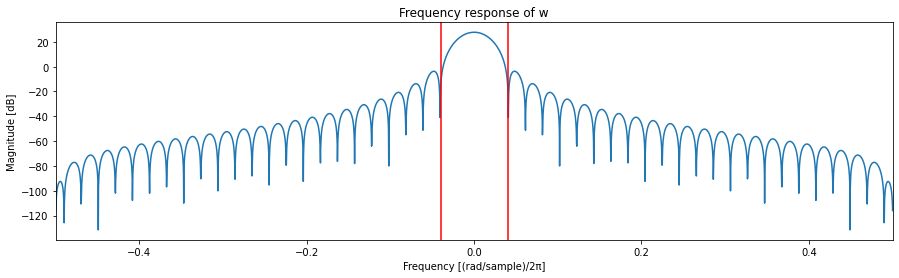

In [112]:
# Defines a Hanning window of length 50
Nw = 50                                 
w = Signal("w", np.hanning(Nw))

# Lower and upper limits of the main lobe (so width = 4/Nw)
xhighlights = [-2/Nw, 2/Nw]

# Plots the DTF of w
w.fft_plot(xhighlights=xhighlights)

In [108]:
N = x.signal.shape[0] # % longueur du signal
Nw = 50
w = np.hanning(Nw)  # définition de la fenetre d'analyse
ws = w.copy   # définition de la fenêtre de synthèse
R = Nw/4 # incrément sur les temps d'analyse, appelé hop size, t_a=uR
M = 512 # ordre de la tfd
L = M/2+1
affich = 1   # pour affichage du spectrogramme, 0 pour
             # pour faire analyse/modif/synthèse sans affichage
             # note: cf. spectrogram sous Matlab
Nt = np.rint((N - Nw) / R) # calcul du nombre de tfd à calculer
Nt = Nt.astype(int)
y = np.zeros((N,1)) # signal de synthèse

if affich:
    Xtilde = np.zeros((M,Nt),dtype=complex)

w = Signal("w", w, freq=32000)
w.fft_plot(window=True)

TypeError: fft_plot() got an unexpected keyword argument &#39;window&#39;

## STFT

The STFT referred to as low-pass convention is defined in dicrete time as:

$$W_x(\\lambda,b)=\\sum_{n\\in \\mathbb Z} x(n)w(n-b)e^{-j2\\pi\\lambda n}$$

In this equation we consider the input signal $x(n)$ and the analysis window in discrete time $w(n-b)$ (where $b$ is a discret and quantized variable) to obtain the filter-bank interpretation. The spectrum of the signal $x$  is first rotated along unit circle in the $z$ plane in that way we shift $\\lambda$ frecuency down to 0. Then, we can see the input signal as:

$$x(n)\\overset{\\Delta}{=} x(n)e^{-j2\\pi\\lambda n}$$

Additionally, the signal is convolved with the window to get $W_x(b)$:

$$W_x(b)=\\sum_{n\\in \\mathbb Z} x(n)w(n-b)= (x \\ast w)(b)$$

At this point, we consider de window $w$ as a low pass filter impulse response. The output $W_x$ is a time-domain signal with a centered componend $e^{-j2\\pi\\lambda n}$ removed by frecuency shifting. Since the analysis of the STFT is symetric and the lenght of the impulse response is odd, then we conlude that is a Type I filter, in the case of an even impulse response we define a Type II filter.